# 1. Setup

## 1.1 Imports

In [27]:
#imports
import torch
from torch.utils.data import Dataset,DataLoader,Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import CrossEntropyLoss

from transformers import BertForSequenceClassification,BertConfig,BertTokenizer

from sklearn.metrics import accuracy_score,precision_score,confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple

import os
import json
import simplejson
import warnings
from pathlib import Path
import pathlib



## 1.2 Cuda

use cuda if available

In [28]:
#define device
device= torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## 1.3 Parameters

This section holds all tuneable parameters of this notebook seperated into different categories according to target area

In [29]:
notebook_parameters={"model_parameters":None,
                     "training_parameters":None,
                     "data_parameters":None,
                     "storage_parameters":None}

### 1.3.1 Model Parameters

dict that will be passed to BertConfig to configure the model used

In [30]:
notebook_parameters["model_parameters"]={"num_hidden_layers":24,
                                         "hidden_dropout_prob":0.1,
                                         "attention_probs_dropout_prob":0.1
                                        }

### 1.3.2 Training Parameters

In [31]:
notebook_parameters["training_parameters"]={"optimizer": Adam,
                                            "optimizer_kwargs": {"lr": 2e-5, "betas":(0.9,0.999)},
                                            "learningrate_scheduler": ExponentialLR,
                                            "update_lr_every_n_batches": -1,
                                            "learningrate_scheduler_kwargs": {"gamma": 0.9},
                                            "number_of_epochs": 2,
                                            "loss_function": CrossEntropyLoss(),
                                            "validate_every_n_batches": 252,
                                            "calc_ewma":True
                                            }

### 1.3.3 Data parameters

In [32]:
notebook_parameters["data_parameters"]={"batchsize":6,
                                        "path_to_train_data":r"C:\path\to\data\english_datasets\en_train.csv",
                                        "train_limit": -1,
                                        "path_to_valid_data":r"C:\path\to\data\english_datasets\en_dev.csv",
                                        "valid_limit": -1,
                                        }

### 1.3.4 Storage parameters

In [33]:
notebook_parameters["storage_parameters"]= {"path_to_model_storage": Path(r"C:\path\to\trainings\trained_models")
                                           }

# 2. Datasets and Transforms

## 2.1 Original Dataset

Create a class that will hold the initial dataset

In [34]:
class Blogpost_dataset(Dataset):
    """
    this class serves as a custom dataset for the given blog posts
    """

    def __init__(self,src_path,transform=None):
        """
        task: inits the dataset and sets optional transforms \n
        parameters: src_path(str(path to the underlying source data)), transform(optional transformation that may be applied to each sample ) \n
        return value:
        """

        self.src_df = pd.read_csv(src_path)
        self.transform= transform
        self.Dataset_item= namedtuple("Dataset_item",["text","label"]) 

    def __len__(self):
        """
        task: return the length of the underlying source DataFrame \n
        parameters:\n
        return value:
        """

        return len(self.src_df)

    def __getitem__(self, index):
        """
        task: return the item at the given index \n
        parameters:\n
        return value:
        """

        #transform the index to a list in case it is a tensor
        if torch.is_tensor(index):
            index= index.tolist()

        #fetch item from source df
        item=self.Dataset_item(self.src_df.iloc[index]["text"],self.src_df.iloc[index]["label"])

        #apply transform if available
        if self.transform:
            item= self.transform(item)

        return item


## 2.2 BERT compatible Dataset

Create a class that will serve as a dataset for the data in BERT compatible, already tokenized form

In [35]:
class Bert_compatible_dataset(Dataset):
    """
    this class holds a dataset that was transformed using the BertTransform
    """

    def __init__(self,input_ids_list,attention_mask_list,token_type_ids_list,label_list,text_list=None,transform=None):
        """
        task: create a dataset from the given lists of tokens. if text_list is given that column will hold the original text \n
        parameters:input_ids_list(list(token id)), attention_mask_list(list(attention mask)),token_type_ids_list(list(token_type_id)) ,label_list(list(label)), text_list(list(optional: orignal text))\n
        return value:
        """

        #create a class that will hold one element of data
        self.Dataset_item= namedtuple("Bert_dataset_item",["input_ids","attention_mask","token_type_ids","label","text"])

        #this list will store all data 
        self.data= []
        
        if text_list:
            #assert that all of those lists are of same length
            assert len(input_ids_list)==len(attention_mask_list)==len(token_type_ids_list)==len(label_list)==len(text_list),"length of lists has to match"
        
            #zip the lists together
            for input_ids,attention_mask,token_type_ids,label,text in zip(input_ids_list,attention_mask_list,token_type_ids_list,label_list,text_list):

                #create a namedtuple storing that data and append it to self.data
                item= self.Dataset_item(input_ids,attention_mask,token_type_ids,label,text)
                self.data.append(item)

        else:
            assert len(input_ids_list)==len(attention_mask_list)==len(token_type_ids_list)==len(label_list),"length of lists has to match"

            #zip the lists together
            for input_ids,attention_mask,token_type_ids,label in zip(input_ids_list,attention_mask_list,token_type_ids_list,label_list):

                #create a namedtuple storing that data and append it to self.data
                item= self.Dataset_item(input_ids,attention_mask,token_type_ids,label,0)
                self.data.append(item)

        self.transform = transform


    def __len__(self):
        """
        task: return the length of self.data field \n
        parameters:\n
        return value:
        """

        return len(self.data)

    def __getitem__(self, index):
        """
        task: return the item at index \n
        parameters:\n
        return value:
        """

        #transform the index to a list in case it is a tensor
        if torch.is_tensor(index):
            index= index.tolist()

        data=self.data[index]

        if self.transform:
            data= self.transform(data)

        return data


## 2.3 Transforms

Create a Transform that will transform bert compatible data into tensors on the given device

In [36]:
class BertToTensor(object):
    """
    This class serves as a transform to transfer the elements of namedtuple into tensors on the given device
    """

    def __init__(self,device="cpu"):
        """
        task:  \n
        parameters:\n
        return value:
        """

        self.device=device

    def __call__(self,named_tuple):
        """
        task: transform the elements of the named tuple into tensors and ship them over to self.device \n
        parameters: named_tuple("Bert_dataset_item",["input_ids","attention_mask","token_type_ids","label","text"]) \n
        return value: transformed elements
        """

        #unpack the named tuple
        input_ids,attention_mask,token_type_ids,label,text = named_tuple

        #transform to tensor
        input_ids= torch.IntTensor(input_ids).to(device=self.device)
        attention_mask= torch.IntTensor(attention_mask).to(device=self.device)
        token_type_ids= torch.IntTensor(token_type_ids).to(device=self.device)
        label= torch.IntTensor(label).to(device=self.device)
        text= torch.IntTensor(text).to(device=self.device)

        return input_ids,attention_mask,token_type_ids,label,text

create a transform that takes the original data as imput and tokenizes it using the BERTTokenizer

In [37]:
class BertTransform(object):
    """
    this class will serve as a transform that tokenizes a given text using the bert tokenizer
    """

    def __init__(self,max_length):
        """
        task: init the transform and creates a bert tokenizer\n
        parameters:\n
        return value:
        """

        self.tokenizer= BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
        self.max_length= max_length

    def __call__(self,item):
        """
        task: when called transform the given items' text field by applying bertTokenization  \n
        parameters:\n
        return value:
        """

        #transform the items text 
        transformed_text= self.tokenizer.encode_plus(
            item.text,
            add_special_tokens=True, #adds beginning(CLS)) and end(SEP) tokens of sequence)
            max_length= self.max_length,
            pad_to_max_length=True, # makes the tokenizer fill the token vectors with padding tokens if the sequence is smaller than max_length
            return_attention_mask = True
        )

        Dataset_item=namedtuple("Dataset_item",["text","label"]) 
        return Dataset_item(transformed_text,item.label)

a method that creates an original dataset and transforms it into a bert compatibel one

In [38]:
def transform_original_dataset_2_bert_compatible(src_path,max_length=512,limit=-1,device="cpu"):
    """
    task: use the BertTokenize transform to tokenize the given original Dataset and thus create a dataset that is bert compatible \n
    parameters: src_path(path to original data), max_length(int(max length allowed for transformer, 512 for bert)),limit(number of entries to use) \n
    return value: torch.utils.data.Dataset
    """

    #create BertTransform
    transform=BertTransform(max_length)

    #create the original Blogpost_dataset
    blogpost_ds=Blogpost_dataset(src_path,transform=transform)

    #pull a subset of the dataset if a limit was given
    if limit>0:
        indices= np.random.choice(range(len(blogpost_ds)),size=limit,replace=False) #choose random indices
        blogpost_ds= Subset(blogpost_ds,indices)

    #lists that will stored the transformed/tokenized text
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []

    #iterate over the dataset with transform and catch the thus transformed texts by putting them into a new dataset
    for transformed_text,label in blogpost_ds:

        #apppend the contents to the corresponding list
        input_ids_list.append(transformed_text['input_ids'])
        token_type_ids_list.append(transformed_text['token_type_ids'])
        attention_mask_list.append(transformed_text['attention_mask'])
        label_list.append([label])

    #return the Bert_compatible_dataset derived from those lists
    return Bert_compatible_dataset(input_ids_list,attention_mask_list,token_type_ids_list,label_list,transform=BertToTensor(device))


## 2.4 Dataset and Dataloader Creation

train dataset/dataloader

In [39]:
#create a bert compatible dataset
bert_train_ds= transform_original_dataset_2_bert_compatible(notebook_parameters["data_parameters"]["path_to_train_data"],limit=notebook_parameters["data_parameters"]["train_limit"],device=device)

#create a corresponding dataloader
bert_train_dl= DataLoader(bert_train_ds,batch_size=notebook_parameters["data_parameters"]["batchsize"],shuffle=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\users\nick\code\machinelearning_projects\bewerbung_nlp\venv\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


validation dataset/dataloader

In [40]:
#create a bert compatible dataset
bert_valid_ds= transform_original_dataset_2_bert_compatible(notebook_parameters["data_parameters"]["path_to_valid_data"],limit=notebook_parameters["data_parameters"]["valid_limit"],device=device)

#create a corresponding dataloader
bert_valid_dl= DataLoader(bert_valid_ds,batch_size=notebook_parameters["data_parameters"]["batchsize"],shuffle=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


# 3. The Model

The model used will be BERT by google. further documentation can be found here: https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification

# 3.1 Training

### 3.1.1 Model and optimizer init

use the Bert Config class to configure the Bert model used

In [41]:
bert_config= BertConfig(**notebook_parameters["model_parameters"]) 

initialize optimizer,learningrate scheduler and model

In [42]:
#init the model
model= BertForSequenceClassification(bert_config).from_pretrained('bert-base-uncased').to(device)

#init optimizer and learning rate scheduler
optimizer= notebook_parameters["training_parameters"]["optimizer"](model.parameters(),**notebook_parameters["training_parameters"]["optimizer_kwargs"]) 
lr_scheduler= notebook_parameters["training_parameters"]["learningrate_scheduler"](optimizer,**notebook_parameters["training_parameters"]["learningrate_scheduler_kwargs"])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### 3.1.2 Loss Function

Given the binary classification problem, the cross entropy loss function comes in quite handy and will be used for this notebook

In [43]:
criterion = notebook_parameters["training_parameters"]["loss_function"]


### 3.1.3 Training loop

In [44]:
def train_model(model,train_dataloader,valid_dataloader,loss_function,optimizer,number_of_epochs,learningrate_scheduler=None,update_lr_every_n_batches=-1, validate_every_n_batches=None,calc_ewma=False,**ewma_kwargs):
    """
    task: train the given model and validate it every n epochs on the validation dataset \n
    parameters:model(torch.nn.Module subclass),loss_func(torch.nn loss function), optimizer(torch.optim optimizer), number_of_epochs(int(number of epochs to train)),learningrate_scheduler(instance of torch.optim.lr_scheduler subclass),validate_every_n_batches(int),calc_ewma(bool(true if ewma shall be calculated)),ewma_kwargs(kwargs that will be passed to ewma calculation) \n
    return value:
    """
    
    #put model into training mode
    model.train()
    
    batch_number=1
    
    if calc_ewma:
        loss_history=pd.DataFrame(columns=["batch_number","train_batch_loss"])
    current_ewma=None
    
    for epoch_id in range(number_of_epochs):
        
        for train_batch_id,train_batch in enumerate(train_dataloader,start=1):
        
            #unpack the batch
            input_ids_list,attention_mask_list,token_type_ids_list,label_list,*_=train_batch

            #zero gradients
            optimizer.zero_grad()

            #forward_pass
            output=model(input_ids_list,attention_mask_list,token_type_ids_list)

            #compute loss
            train_batch_loss=criterion(output.logits,label_list.flatten().to(dtype=torch.long))
            train_batch_loss.backward()

            #optimize
            optimizer.step()

            #check if validation necessary, if so do it
            average_validation_loss=None
            if validate_every_n_batches and batch_number%validate_every_n_batches==0:
                
                #put model into evaluation mode
                model.eval()
                
                validation_losses=[]
                with torch.no_grad():
                    for valid_batch in valid_dataloader:
                        
                        #unpack batch
                        input_ids_list,attention_mask_list,token_type_ids_list,label_list,*_=valid_batch
                        
                        #evaluate the inputs with model
                        output=model(input_ids_list,attention_mask_list,token_type_ids_list)
                        
                        #calc validation batch loss
                        valid_batch_loss=criterion(output.logits,label_list.flatten().to(dtype=torch.long))
                        
                        #append the loss to all validation_losses
                        validation_losses.append(valid_batch_loss)
            
                #calculate the average loss
                average_validation_loss=sum(validation_losses)/len(validation_losses)
            
                #reset model to train mode
                model.train()
            
            #calc ewma if desired
            if calc_ewma:
                loss_history=loss_history.append({"batch_number": batch_number,
                                                  "train_batch_loss": train_batch_loss}
                                                  ,ignore_index=True)
                current_ewma=loss_history.ewm(**ewma_kwargs).mean().iloc[-1]["train_batch_loss"]

            #get last lr if available
            last_lr= None if not learningrate_scheduler else learningrate_scheduler.get_last_lr()[-1]
            
            #execute step of lr scheduler if available
            if learningrate_scheduler and update_lr_every_n_batches>0 and batch_number%update_lr_every_n_batches==0:
                learningrate_scheduler.step()
            
            #increase batch number
            batch_number+=1
            
            #yield training info about current batch
            yield epoch_id,train_batch_id, train_batch_loss,average_validation_loss,current_ewma,last_lr
            

use that train_model method and create a plot about the generated training info

<IPython.core.display.Javascript object>


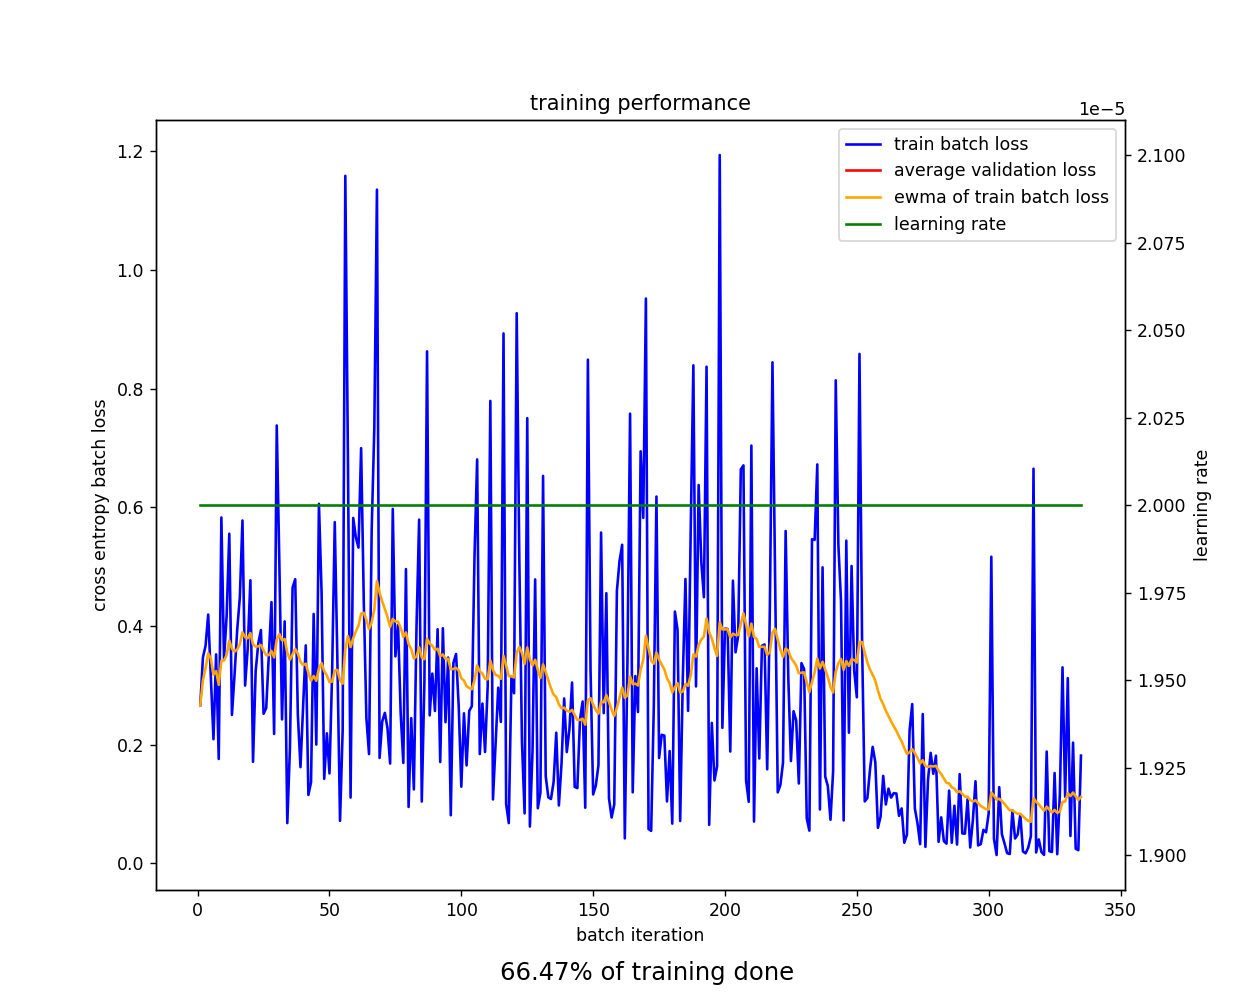

[epoch 0 _ batch 1]: loss= 0.26658573746681213
[epoch 0 _ batch 2]: loss= 0.3469292223453522
[epoch 0 _ batch 3]: loss= 0.366543173789978
[epoch 0 _ batch 4]: loss= 0.41924023628234863
[epoch 0 _ batch 5]: loss= 0.31396421790122986
[epoch 0 _ batch 6]: loss= 0.2092202752828598
[epoch 0 _ batch 7]: loss= 0.3521782457828522
[epoch 0 _ batch 8]: loss= 0.175938680768013
[epoch 0 _ batch 9]: loss= 0.5828585624694824
[epoch 0 _ batch 10]: loss= 0.3446923494338989
[epoch 0 _ batch 11]: loss= 0.41764453053474426
[epoch 0 _ batch 12]: loss= 0.5554352402687073
[epoch 0 _ batch 13]: loss= 0.25014230608940125
[epoch 0 _ batch 14]: loss= 0.3182283639907837
[epoch 0 _ batch 15]: loss= 0.3931879699230194
[epoch 0 _ batch 16]: loss= 0.44822487235069275
[epoch 0 _ batch 17]: loss= 0.5777302384376526
[epoch 0 _ batch 18]: loss= 0.2995908260345459
[epoch 0 _ batch 19]: loss= 0.3628585636615753
[epoch 0 _ batch 20]: loss= 0.47697916626930237
[epoch 0 _ batch 21]: loss= 0.17119617760181427
[epoch 0 _ batch

[epoch 0 _ batch 173]: loss= 0.26542043685913086
[epoch 0 _ batch 174]: loss= 0.6180718541145325
[epoch 0 _ batch 175]: loss= 0.1775137335062027
[epoch 0 _ batch 176]: loss= 0.21669761836528778
[epoch 0 _ batch 177]: loss= 0.21537776291370392
[epoch 0 _ batch 178]: loss= 0.10442295670509338
[epoch 0 _ batch 179]: loss= 0.1892949789762497
[epoch 0 _ batch 180]: loss= 0.06704425066709518
[epoch 0 _ batch 181]: loss= 0.4243307113647461
[epoch 0 _ batch 182]: loss= 0.39344120025634766
[epoch 0 _ batch 183]: loss= 0.07147624343633652
[epoch 0 _ batch 184]: loss= 0.31297579407691956
[epoch 0 _ batch 185]: loss= 0.47923341393470764
[epoch 0 _ batch 186]: loss= 0.25700798630714417
[epoch 0 _ batch 187]: loss= 0.5634704232215881
[epoch 0 _ batch 188]: loss= 0.8391070365905762
[epoch 0 _ batch 189]: loss= 0.29815348982810974
[epoch 0 _ batch 190]: loss= 0.6375274062156677
[epoch 0 _ batch 191]: loss= 0.5092861652374268
[epoch 0 _ batch 192]: loss= 0.44844844937324524
[epoch 0 _ batch 193]: loss=

KeyboardInterrupt: 

In [56]:
%matplotlib notebook

#lists for batch_loss
batch_number_list=[None]
batch_train_loss_list=[None]

#lists for average validation loss
batch_number_avg_valid_loss_list=[None]
avg_valid_loss_list=[None]

#list for ewma
ewma_list=[None]

#list for lr
lr_list=[None]

#create figure and seperate plots for batch_loss,average validation_loss, ewma and lr 
plt.ion()
info_fig,axes= plt.subplots(figsize=(10,8))
batch_train_plot, = axes.plot(batch_number_list,batch_train_loss_list,"blue",label="train batch loss")
average_valid_plot, =axes.plot(batch_number_list,avg_valid_loss_list, "red",label="average validation loss")
ewma_plot, =axes.plot(batch_number_list,ewma_list,"orange",label="ewma of train batch loss")

#create twin axes to allow second y axis
twin_axes= axes.twinx()
lr_plot, = twin_axes.plot(batch_number_list,lr_list,"green",label="learning rate")

#set figure attributes like title,labels and legend
plt.title("training performance")
axes.set_xlabel("batch iteration")
axes.set_ylabel("cross entropy batch loss")
twin_axes.set_ylabel("learning rate")

#create legend
plots= [batch_train_plot,average_valid_plot,ewma_plot,lr_plot]
plt.legend(plots,[plot.get_label() for plot in plots])

#position text to display training progress
plt.gcf().text(0.4,0.02,"0.00% of training done",fontsize=14)

batch_number=1

#execute the training loop and print the training info
for epoch_id,train_batch_id,train_batch_loss,average_valid_loss,ewma,last_lr in train_model(model,bert_train_dl,bert_valid_dl,criterion,optimizer,notebook_parameters["training_parameters"]["number_of_epochs"],lr_scheduler,update_lr_every_n_batches=notebook_parameters["training_parameters"]["update_lr_every_n_batches"] ,validate_every_n_batches=notebook_parameters["training_parameters"]["validate_every_n_batches"],calc_ewma=notebook_parameters["training_parameters"]["calc_ewma"],halflife=10):
    
    #print training info
    print(f"[epoch {epoch_id} _ batch {train_batch_id}]: loss= {train_batch_loss}")

    #calculate the percentage of training done and add it as text
    percentage_done= round(batch_number/(notebook_parameters["training_parameters"]["number_of_epochs"]*len(bert_train_dl))*100,2)
    info_fig.texts[0].set_text(f"{percentage_done:.2f}% of training done")
    
    #add the new data to corresponding lists
    batch_number_list.append(batch_number)
    batch_train_loss_list.append(train_batch_loss)
    ewma_list.append(ewma)
    lr_list.append(last_lr)
    if average_valid_loss:
        batch_number_avg_valid_loss_list.append(batch_number)
        avg_valid_loss_list.append(average_valid_loss)
    
    #update plot with current training info
    batch_train_plot.set_data(batch_number_list,batch_train_loss_list)
    average_valid_plot.set_data(batch_number_avg_valid_loss_list,avg_valid_loss_list)
    ewma_plot.set_data(batch_number_list,ewma_list)
    lr_plot.set_data(batch_number_list,lr_list)
    
    #relimit axes to show newly created data and autoscale
    axes.relim()
    axes.autoscale_view(True,True,True)
    twin_axes.relim()
    twin_axes.autoscale_view(True,True,True)
    
    #show updates
    info_fig.canvas.draw()
    info_fig.canvas.flush_events()
    
    #increase batch number
    batch_number+=1
    

## 3.2 Model evaluation

write a class that composes several metrics to allow composed metric evalution

In [46]:
class Metric_composer():
    """
    this class is used to evaluate model predictions on multiple metrics simultaneously
    """
    
    def __init__(self,metrics_dict):
        """
        task: init composer and set its metrics field \n
        parameters:metrics_dict(sting(metric name): callable(metric func))\n
        return value:
        """
        
        self.metrics= metrics_dict
        
    def evaluate(self,y_truth,y_pred):
        """
        task: use the metrics in the self.metrics field to evaluate the given y values \n
        parameters: y_truth(ground truth labels), y_pred(predicted labels) \n
        return value: dict(string(name):evaluation of corresponding function)
        """
    
        evaluation={}
        for name,metric_func in self.metrics.items():
            
            evaluation[name]= metric_func(y_truth,y_pred)
            
        return evaluation
    

a method to evaluate a given model using the data from given dataloader and the metrics composed within the metric_composer_obj 

In [47]:
def eval_model(model,dataloader,metric_composer_obj):
    """
    task: evaluate the model on the given dataloader using the loss_func \n
    parameters: model(torch.nn.Module subclass), dataloader(torch.utils.data.DataLoader instance), metric_composer_obj(instance of Metric_composer) \n
    return value:
    """
    
    #put model into evaluation mode
    model.eval()
    
    y_pred=[]
    y_truth=[]
    with torch.no_grad():
        
        for batch in dataloader:
            
            #unpack the batch
            input_ids_list,attention_mask_list,token_type_ids_list,label_list,*_=batch
            
            #evalaute batch with model
            output=model(input_ids_list,attention_mask_list,token_type_ids_list)
            
            #model outputs a prob distribution over the 2 classes, so get argmax to retreive predicted label
            predicted_labels=torch.argmax(output.logits, axis=1).flatten()
    
            #append both the predicted labels and the true labels 
            y_pred+=predicted_labels.tolist()
            y_truth+=label_list.flatten().tolist()
            
            
    return metric_composer_obj.evaluate(y_truth,y_pred)

compose metrics

In [48]:
#compose different performance metrics
metric_composer_obj= Metric_composer({
    "accuracy": accuracy_score,
    "precision": precision_score,
    "confusion_matrix": confusion_matrix
})

evaluate performance on train data

In [57]:
#iterate over all evaluations and print them
train_evaluation=eval_model(model,bert_train_dl,metric_composer_obj)
for metric_name, metric_evaluation in train_evaluation.items():
    print(f"----{metric_name}----")
    print(metric_evaluation)
    print("---------------------")

----accuracy----
0.9861111111111112
---------------------
----precision----
0.9973154362416108
---------------------
----confusion_matrix----
[[748   2]
 [ 19 743]]
---------------------


evaluate performance on validation data

In [58]:
#iterate over all evaluations and print them
valid_evaluation=eval_model(model,bert_valid_dl,metric_composer_obj)
for metric_name, metric_evaluation in valid_evaluation.items():
    print(f"----{metric_name}----")
    print(metric_evaluation)
    print("---------------------")

----accuracy----
0.6455026455026455
---------------------
----precision----
0.6710526315789473
---------------------
----confusion_matrix----
[[71 25]
 [42 51]]
---------------------


## 3.3 Store/load the model 

### 3.3.1 store model

In [51]:
def store_model(model,description,dest_path):
    """
    task: store the given model together with a txt file that stores a short description \n
    parameters:model(torch.nn.Module), description(dict), dest_path(each stored model will be stored in a folder containing state_dict and description.txt, this defines the name of the folder)\n
    return value:
    """
    
    #create the folder at dest_path if not available
    os.mkdir(str(dest_path))
    
    #store the description in a description.json file
    with open(dest_path.joinpath("description.json"),"w") as f:
        f.write(simplejson.dumps(description, indent=4, sort_keys=True))
    
    #store the models state dict
    torch.save(model.state_dict(), str(dest_path.joinpath("state_dict.pth")))

method to force serializability of any dictionary. Used to serialize the notebook_paramters dict when storing a model

In [52]:
def recursive_force_serializability(dict_to_transform,max_depth=100,caller_depth=0,replace_unstringable=False):
    """
    task: convert any non-serializable object within that dict to string and thus force serialiazability  \n
    parameters:dict_to_transform(dict), max_depth(int(max depth for recursive calls)),caller_depth(int(depth of the caller)), replace_unstringable=\n
    return value:
    """
    
    #create a copy of the original dict in case the caller_depth==0
    if caller_depth==0:
        dict_to_transform= dict_to_transform.copy()
    
    current_depth=caller_depth+1
    
    #recursion anker
    if current_depth==max_depth:
        warnings.warn("exceeded given recursion depth. Unable to fully transform given dictionary")
        return dict_to_transform
    
    #call ,method recursively on the items of the dict if they are dicts as well, in case of unserializable items convert them to strings if possible
    for key,item in dict_to_transform.items():
        if type(item)==dict:
            dict_to_transform[key]= recursive_force_serializability(item,max_depth=max_depth,caller_depth=current_depth,replace_unstringable=replace_unstringable)
        else:
            #try to dump the item to check ifg its serializable
            try:
                json.dumps(item)
            except TypeError:
                #if not serializable try to transform it to string
                try:
                    dict_to_transform[key]=str(item)
                except TypeError:
                    #if not stringable replace by "unserializable and unstringable object" string if replace_unstringable==True, else raise error
                    if replace_unstringable:
                        dict_to_transform[key]="unserializable and unstringable object"
                        warnings.warn(f"replaced object at key {key} with replacement string")
                    else:
                        raise AssertionError("unserializable and unstringable object was found and replace_unstringable is set to False, set to True if replacement is desired")
                    
    return dict_to_transform

derive a desription dictionary from notebook_parameters and optional train/validation evaluations

In [53]:
def create_model_description(notebook_parameters=None,train_evaluation=None,valid_evaluation=None):
    """
    task: create a description of the model by storing the notebook_parameters used and evaluation scores   \n
    parameters: notebook_parameters(dict at beginning of notebook), train_evaluation(output of Model_composer.evaluate on train data),valid_evaluation(output of Model_composer.evaluate on validation data) \n
    return value: dict
    """
    
    description={
        "notebook_parameters": notebook_parameters,
        "train_evaluation": train_evaluation if train_evaluation else "no train evaluation available",
        "valid_evaluation": valid_evaluation if valid_evaluation else "no validation evaluation available"
    }

    return description
    

In [54]:
#store the current run
folder_name="chinese_v2_1er-precision"
if False: #change to true if desired
    desc= create_model_description(notebook_parameters,train_evaluation,valid_evaluation)
    dest_folder=notebook_parameters["storage_parameters"]["path_to_model_storage"].joinpath(folder_name)
    store_model(model,recursive_force_serializability(desc,max_depth=100),dest_folder)

### 3.3.2 load model

In [55]:
#load the model in given folder name
folder_name="chinese_v1"
if False: #change to true if desired
    model.load_state_dict(torch.load(notebook_parameters["storage_parameters"]["path_to_model_storage"].joinpath(folder_name,"state_dict.pth")))

# 4. Result 

Unfortunately there are no BertTokenizers directly addressed to the english language, which is the reason for the usage of uncased tokenizer and model in this notebook. Propably that is the reason why I found it hard to train models from this notebook that outperformed either the Distil version or its chinese Bert counterpart.    